# spaCy experiments

## Imports & initialization

Import the required modules.

In [1]:
import collections
import itertools
import matplotlib.pyplot as plt
import numpy as np
import spacy

Create a language model, English in this case.

In [2]:
en_nlp = spacy.load('en_core_web_sm')

## Part of speech tagging (POS)

Read a text file into a string variable.

In [ ]:
with open('Data/frost.txt') as file:
    text = ''.join(file.readlines())

Parse the text using the language model.

In [ ]:
doc = en_nlp(text)

Show the part of speech tags, as well as the context of the words.

In [ ]:
for word in doc:
    print(f'{word.text!r}: {word.pos_}, '
          f'{word.left_edge.text!r} <- {word.head.text!r} -> {word.right_edge.text!r}')

Since we can't use backslashes in f-strings, we define a constant to represent it.

In [ ]:
newline = '\n'

To split a text in sentences, a statistical model is used that was obtained from the training corpus.

In [ ]:
for i, sentence in enumerate(doc.sents):
    print(f'{i:3d} {sentence.text.replace(newline, " ")}')

For poetry, sentences seem somewhat hard to detect.  However, it is possible to define a language model for English and add a rule-based sentencizer to it.

In [ ]:
en_nlp_alt = spacy.lang.en.English()
sentencizer = en_nlp_alt.create_pipe('sentencizer')
en_nlp_alt.add_pipe(sentencizer)
doc = en_nlp_alt(text)
for i, sentence in enumerate(doc.sents):
    print(f'{i:3d} {sentence.text.replace(newline, " ").strip()}')

## Lemmatization

By way of example, consider Plato's *Republic*.  This is a fairly long text.

In [ ]:
!wc -l -w Data/republic.mb.txt

In [ ]:
with open('Data/republic.mb.txt') as file:
    text = ''.join(file.readlines())

The full result of the language model parsing this text would be rather large, but for our purposes, we require only tokenization, not POS or NER, hence we disable these features.

In [ ]:
doc = en_nlp(text, disable=['parser', 'ner'])

We can now perform lemmatization on all words that are not stop words, and we also eliminate named entities (`-PROP-` as value for lemma) and punctuation.  On the resulting list, a word count is performed.

In [ ]:
stopwords = en_nlp.Defaults.stop_words | {'\n', '\n\n', '-PRON-'}
punctuation = ',.;?!:-'
counts = collections.Counter([token.lemma_.lower() for token in doc
                              if token.lemma_ not in stopwords and token.lemma_ not in punctuation])

The top-20 words are given below.

In [ ]:
counts.most_common(20)

In [ ]:
def plot_distr(counts, nr_words):
    words = list()
    numbers = list()
    for word, number in counts.most_common(nr_words):
        words.append(word)
        numbers.append(number)
    figure, axes = plt.subplots(1, 1, figsize=(15, 5))
    axes.bar(words, numbers)
    axes.set_xticklabels(words, rotation=45)

In [ ]:
plot_distr(counts, 30)

## Named entiry recognition (NER)

Named entity recognition is supported as well.

In [ ]:
sentence = 'Music by Johann Sebastian Bach is better than that by Friederich Buxtehude. Both lived in Germany'

In [ ]:
doc = en_nlp(sentence)

In [ ]:
for i, word in enumerate(doc):
    print(f'{i:3d} {word.text!r}: {word.pos_}, {word.ent_type_}')

It is also possible to retrieve named entities from the document explicitly.

In [ ]:
for entity in doc.ents:
    print(f'{entity} ({entity.label_}): {entity.start} -> {entity.end}')

Note that the first name of Buxtehude is in fact Dietrich, not Friederich.  Nevertheless, the NER marks `Friederich Buxtehude` as a person.

This can also be visualized as markup in the sentence.

In [ ]:
spacy.displacy.render(doc, style='ent', jupyter=True)

In [ ]:
spacy.displacy.render(doc, style='dep', jupyter=True,
                      options={'distance': 140, 'compact': True})

## Similarity

Document similarity can also be computed conveniently.

In [3]:
doc1 = en_nlp('The book is nice')
doc2 = en_nlp('The novel is beautiful')
doc1.similarity(doc2)

0.8147012719178897

In [4]:
doc1 = en_nlp('The book is nice')
doc2 = en_nlp('The house is on fire')
doc1.similarity(doc2)

0.7543920170936133

In [5]:
words = ['queen', 'lady', 'girl', 'king', 'lord', 'boy', 'cat', 'dog', 'lion']
similarity = np.empty((len(words), len(words)))
for i, word1 in enumerate(words):
    for j, word2 in enumerate(words):
        similarity[i, j] =  en_nlp(word1).similarity(en_nlp(word2))

The similarity matrix can be visualized as a heat map using the following function:

In [6]:
def plot_similarity_matrix(sim, words, cmap=plt.cm.Blues):
    figure, axes = plt.subplots(figsize=(6, 6))
    axes.imshow(sim, interpolation='nearest', cmap=cmap)
    axes.set_xticks(range(len(words)))
    axes.set_xticklabels(words, rotation=45)
    axes.set_yticks(range(len(words)))
    axes.set_yticklabels(words)
    fmt = '{0:.2f}'
    thresh = 0.5*(sim.max() + sim.min())
    for i, j in itertools.product(range(sim.shape[0]), range(sim.shape[1])):
        axes.text(j, i, fmt.format(sim[i, j]),
                  horizontalalignment="center",
                  color="white" if sim[i, j] > thresh else "black",
                  fontsize=8)
    figure.tight_layout()
    axes.set_xlabel('word 1')
    axes.set_ylabel('word 2')

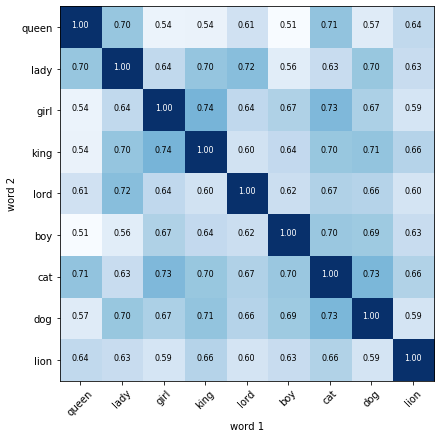

In [7]:
plot_similarity_matrix(similarity, words)

However, small language models don't contain real word vectors, only context sensitive tensors.  We can repeat the computation above with a medium sized language model.

In [8]:
en_nlp_md = spacy.load('en_core_web_md')

In [12]:
similarity = np.empty((len(words), len(words)))
for i, word1 in enumerate(words):
    for j, word2 in enumerate(words):
        similarity[i, j] =  en_nlp_md(word1).similarity(en_nlp_md(word2))

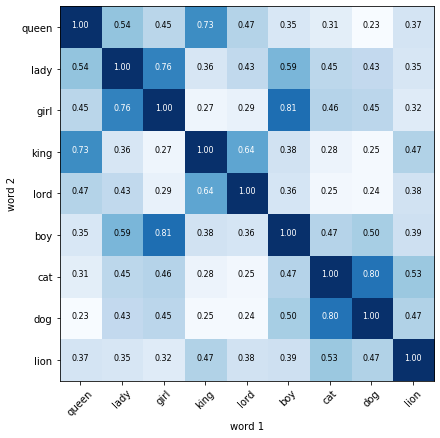

In [13]:
plot_similarity_matrix(similarity, words)

In [14]:
doc1 = en_nlp_md('The book is nice')
doc2 = en_nlp_md('The novel is beautiful')
doc1.similarity(doc2)

0.8668694414738268

In [15]:
doc1 = en_nlp_md('The book is nice')
doc2 = en_nlp_md('The house is on fire')
doc1.similarity(doc2)

0.7675483446021452

In [16]:
doc1 = en_nlp_md('Stock prices for Intel are on the rise.')
doc2 = en_nlp_md('The value of NVIDIA shares is increasing.')
doc1.similarity(doc2)

0.8168349139397068

In [17]:
doc1 = en_nlp_md('Stock prices for Intel are on the rise.')
doc2 = en_nlp_md('The economy of Denmark is flourishing.')
doc1.similarity(doc2)

0.7249704452291487

In [18]:
doc1 = en_nlp_md('Stock prices for Intel are on the rise.')
doc2 = en_nlp_md('The value of NVIDIA shares is plumetting.')
doc1.similarity(doc2)

0.7943866493633162